# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed. 



In [1]:
# %%capture --no-stderr
# %pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
# Set up the environment variables
import os
from dotenv import load_dotenv

load_dotenv()

# Set for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangChain Academy-LangGraph"

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

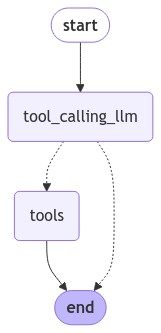

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply])) # A node that runs the tools called in the last AIMessage.
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
help(ToolNode)

Help on class ToolNode in module langgraph.prebuilt.tool_node:

class ToolNode(langgraph.utils.runnable.RunnableCallable)
 |  ToolNode(tools: 'Sequence[Union[BaseTool, Callable]]', *, name: 'str' = 'tools', tags: 'Optional[list[str]]' = None, handle_tool_errors: 'Optional[bool]' = True) -> 'None'
 |
 |  A node that runs the tools called in the last AIMessage.
 |
 |  It can be used either in StateGraph with a "messages" key or in MessageGraph. If
 |  multiple tool calls are requested, they will be run in parallel. The output will be
 |  a list of ToolMessages, one for each tool call.
 |
 |  The `ToolNode` is roughly analogous to:
 |
 |  ```python
 |  tools_by_name = {tool.name: tool for tool in tools}
 |  def tool_node(state: dict):
 |      result = []
 |      for tool_call in state["messages"][-1].tool_calls:
 |          tool = tools_by_name[tool_call["name"]]
 |          observation = tool.invoke(tool_call["args"])
 |          result.append(ToolMessage(content=observation, tool_call_i

In [7]:
messages = graph.invoke({"messages": ("user", "Hello")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hi there! How can I assist you today?


In [5]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 and 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_WYT9qhOnwPlRwCy8pld51pwC)
 Call ID: call_WYT9qhOnwPlRwCy8pld51pwC
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: multiply

6


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.